In [58]:
%matplotlib inline
import time
import copy
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gru_ode_bayes 
import gru_ode_bayes.data_utils as data_utils
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from gru_ode_bayes import Logger
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components

In [2]:
file_path="D:/mimic_iii/clean_data/"
csv_file_path =file_path+"GRU_ODE_Dataset.csv"
covs_file_path=file_path+"GRU_ODE_covariates.csv"
tags_file_path=file_path+"GRU_ODE_death_tags.csv"
saps_file_path=file_path+"GRU_ODE_sapsii.csv"

In [3]:
import pickle

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [4]:
# ロード
d=pickle_load( file_path+'sample_unique_id_dict.pickle')


In [5]:
idx=np.array(list(d.keys()))

In [6]:
dir_path=r"D:/mimic_iii/clean_data/"
train_idx = np.load(dir_path+r"fold_idx_0/train_idx.npy") 
val_idx = np.load(dir_path+r"fold_idx_0/val_idx.npy") 
test_idx = np.load(dir_path+r"fold_idx_0/test_idx.npy")

In [7]:
print(max(train_idx),min(train_idx))
print(max(val_idx),min(val_idx))
print(max(test_idx),min(test_idx))

21260 0
21256 4
21251 30


## covariateの対応表を作成
(np.argmaxでcovをカテゴリ化する際に、コードがずれるのを防ぐため)

In [8]:
cov_df=pd.read_csv(covs_file_path)

In [9]:
np.argmax(cov_df.iloc[:,1:].to_numpy(), axis=1)

array([199, 199, 200, ..., 320, 190, 416], dtype=int64)

In [10]:
cov_list=list(cov_df.columns)
cov_list.pop(0)

'ID'

In [11]:
cov_dict={}
for i,cov in enumerate(cov_list):
    cov_dict[i]=cov

In [12]:
# # このdictでargmax->ICD9Code化する
# cov_dict

In [13]:
# testdataを使う場合
data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
                                    cov_file= covs_file_path, idx=test_idx, validation = False,
                                    val_options =None)

In [14]:
data_test[10]

{'idx': 10,
 'y': array([0.], dtype=float32),
 'path':     Time   Value_0   Value_1   Value_2   Value_3   Value_4   Value_5  \
 ID                                                                     
 10   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10   2.0  0.421422  0.069531  2.181601 -0.468983 -0.518924  0.346238   
 10   9.0  0.000000  0.000000  0.000000  0.000000  0.000000 -1.492335   
 10  24.0  0.168715 -0.369888  0.418962 -0.011129 -0.518924 -0.408890   
 10  26.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 ..   ...       ...       ...       ...       ...       ...       ...   
 10  92.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10  93.0 -0.842112  0.508950  0.308797 -0.011129 -0.657312 -0.025854   
 10  94.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10  95.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10  96.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 

## sapsiiなどのために、DataLoaderとDatasetのIDの対応表を作成
ODE_Datasetの実装はIDがtext_idxに含まれている行を抽出して、pd.uniqueで前からIDを振りなおしている。それに合わせてあらかじめsapsiiスコアを抽出しておく。<br>
DataLoaderのオプションでshuffle=Falseとしているので、順番は一致する。

In [15]:
data = pd.read_csv(csv_file_path)

In [16]:
data.tail()

ID  Time   Value_0   Value_1   Value_2   Value_3   Value_4  \
552322  21249.0  58.0  0.000000  0.000000  0.000000  0.000000  0.000000   
552323  21249.0  70.0  0.000000  0.000000  0.000000  0.000000  0.000000   
552324  21249.0  71.0  0.000000  0.000000  0.000000  0.000000  0.000000   
552325  21249.0  77.0 -0.336698 -1.029017 -1.674172  1.057197 -0.657312   
552326  21249.0  89.0  0.000000  0.000000  0.000000  0.000000  0.000000   

         Value_5  Value_6   Value_7  ...  Mask_86  Mask_87  Mask_88  Mask_89  \
552322  0.000000  0.00000  0.000000  ...      0.0      0.0      0.0      0.0   
552323  0.000000  0.00000  0.000000  ...      0.0      0.0      0.0      0.0   
552324  0.000000  0.00000  0.000000  ...      0.0      0.0      0.0      0.0   
552325 -0.901365 -0.00357 -0.506343  ...      0.0      0.0      0.0      0.0   
552326  0.000000  0.00000  0.000000  ...      0.0      0.0      0.0      0.0   

        Mask_90  Mask_91  Mask_92  Mask_93  Mask_94  Mask_95  
552322      0.0      0.0      0.0      0.0      0.0      0.0  
552323      0.0      0.0      0.0      0.0      0.0      0.0  
552324      0.0      0.0      0.0      0.0      0.0      0.0  
552325      0.0      0.0      0.0      0.0      0.0      0.0  
552326      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 194 columns]

後日対応、Datasetの数が減っている。死亡タグやsapsiiスコアはDatasetとIDでそろえられているので整合性は破綻の心配なし。

In [17]:

test_idx = test_idx[test_idx<21250]
max(test_idx)

21237

In [18]:
## from gru_ode_bayse data_utils.py
# self.df = self.df.loc[self.df["ID"].isin(idx)].copy() 
# map_dict= dict(zip(self.df["ID"].unique(),np.arange(self.df["ID"].nunique())))
# self.df["ID"] = self.df["ID"].map(map_dict) # Reset the ID index.
data = data.loc[data["ID"].isin(test_idx)].copy()
## dataloader id -> dataset ID
map_dict = dict(zip(data["ID"].unique(),np.arange(data["ID"].nunique())))
len(map_dict.keys()),len(test_idx)

(2126, 2126)

このmap_dictを利用することで、DataLoaderから出てくる順番（value）と、もとのデータセットのID(key)が連動する。

In [19]:
dl   = DataLoader(dataset=data_test, collate_fn=data_utils.custom_collate_fn, shuffle=False, batch_size=100,num_workers=4)

In [20]:
#Model parameters.
params_dict=dict()
params_dict["hidden_size"] = 100
params_dict["p_hidden"] = 25
params_dict["prep_hidden"] = 10
params_dict["logvar"] = True
params_dict["mixing"] = 1e-4 #Weighting between KL loss and MSE loss.
params_dict["delta_t"]=0.1
params_dict["T"]= 100  #100
# lambda>0のときClassificationを行う
params_dict["lambda"] = 1 #Weighting between classification and MSE loss.
# lambda==0でないとき、validationオプションはなしにされている(validation==False)
# validationがないときは、summaryのcorrelation,validation_mse,loglik_lossは計算されず0で記録される

params_dict["classification_hidden"] = 2
params_dict["cov_hidden"] = 50
params_dict["weight_decay"] = 0.0001
params_dict["dropout_rate"] = 0
params_dict["lr"]=0.001
params_dict["full_gru_ode"] = True
params_dict["no_cov"] = False # covファイルが存在するときFalse
params_dict["impute"] = False


params_dict["input_size"]=data_test.variable_num
params_dict["cov_size"] = data_test.cov_dim

In [21]:
# model instance 生成
device = torch.device("cuda")
model = gru_ode_bayes.NNFOwithBayesianJumps(input_size = params_dict["input_size"], hidden_size = params_dict["hidden_size"],
                                            p_hidden = params_dict["p_hidden"], prep_hidden = params_dict["prep_hidden"],
                                            logvar = params_dict["logvar"], mixing = params_dict["mixing"],
                                            classification_hidden=params_dict["classification_hidden"],
                                            cov_size = params_dict["cov_size"], cov_hidden = params_dict["cov_hidden"],
                                            dropout_rate = params_dict["dropout_rate"],full_gru_ode= params_dict["full_gru_ode"], impute = params_dict["impute"])
model.to(device)

NNFOwithBayesianJumps(
  (p_model): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=25, out_features=192, bias=True)
  )
  (classification_model): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
  (gru_c): FullGRUODECell_Autonomous(
    (lin_hh): Linear(in_features=100, out_features=100, bias=False)
    (lin_hz): Linear(in_features=100, out_features=100, bias=False)
    (lin_hr): Linear(in_features=100, out_features=100, bias=False)
  )
  (gru_obs): GRUObservationCellLogvar(
    (gru_d): GRUCell(960, 100)
    (gru_debug): GRUCell(960, 100)
  )
  (covariates_map): Sequential(
    (0): Linear(in_features=530, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=50, out_features=100, bias=True

In [22]:
# model parameter load
model_path = r'D:/mimic_iii/clean_data/trained_models/Xval_AUC_GRU_ODE_MIMIC_Binned2_NoImpute_dropout0.2_weightdecay0.0001_lambda1_fold0_MAX.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [23]:
cov_latent_dict=dict()
with torch.no_grad():
    model.eval()
    for i, b in tqdm(enumerate(dl),total=len(dl)):
        times    = b["times"]
        time_ptr = b["time_ptr"]
        X        = b["X"].to(device)
        M        = b["M"].to(device)
        obs_idx  = b["obs_idx"]
        cov_np   = np.argmax(b["cov"].numpy(), axis=1)  #latent_vec取得用
        cov_np   = np.array([cov_dict[i] for i in cov_np])
        cov      = b["cov"].to(device)
        labels   = b["y"].to(device)
        batch_size = labels.size(0)
        #time_series = [[]*batch_size]
        #for j, t in enumerate(time_ptr):
            #if j==0:
            #    t0 = t
            #    continue
            #for k in obs[t0:t]:
                # time_series[k].append(j-1)
        if b["X_val"] is not None:
            X_val     = b["X_val"].to(device)
            M_val     = b["M_val"].to(device)
            times_val = b["times_val"]
            times_idx = b["index_val"]
        h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)
        hT, loss, class_pred, t_vec, p_vec, h_vec, _, _,_,_  = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)

        sl = [0]+[134+132*i for i in range(8)]+[len(h_vec)-1]
        cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"h_path":h_vec.cpu().detach().numpy()[sl,:,:],"y":b["y"].numpy().squeeze()}

100%|██████████| 22/22 [00:16<00:00,  1.37it/s]


In [24]:
print(cov_np)
print(len(data_test))
print(i)
print(len(b["y"]))
print(batch_size)
print(len(cov_latent_dict))
print(cov_latent_dict[0]["h0"].shape)
print(cov_latent_dict[21]["h_path"].shape)
print(hT.shape)
print(h_vec.shape)
print(class_pred.shape)

['584' '428' '414' '600' '806' '414' '414' '519' '574' '038' '323' '414'
 '410' '584' '486' '441' '507' '416' '424' '403' '038' 'V58' '518' '532'
 '414' '584']
2126
21
26
26
22
(100, 100)
(10, 26, 100)
torch.Size([26, 100])
torch.Size([1099, 26, 100])
torch.Size([26, 1])


In [25]:
print(times)
print(time_ptr)
print(len(time_ptr))
print(X.shape)
print(M.shape)
print(obs_idx.shape)
print(obs_idx.detach().numpy().max())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96.]
[  0  26  27  29  31  33  34  35  37  39  40  41  43  46  48  53  56  60
  63  65  68  73  78  83  89  95  99 101 104 108 113 116 121 124 132 137
 144 148 153 160 166 174 181 186 191 199 205 213 221 233 241 250 256 264
 273 280 289 299 303 310 316 325 330 337 342 347 353 360 366 374 378 383
 388 394 401 407 413 419 424 432 439 450 455 462 469 475 482 488 495 502
 510 518 524 532 542 549 555 557]
98
torch.Size([557, 96])
torch.Size([557, 96])
torch.Size([557])
25


h0はICD9から出てくるので時間非依存で1時刻分はある。T=100, delta_t=0.1であるため、100timebin分の潜在変数の更新は1001回起きる（両端+終端でも評価後の値が出てくるため）。
さらにtimebinごとに値が入っていてもいなくても変数の更新は起きる。同一サンプル内で観測されている入力変数がない場合はhはそのまま、いずれかある場合はマスクはかかるが演算により変化する。
そのため、変数の更新はデータが入っている97bin(48時間・2bin/hour・両端)分だけ起きる。すべて合計するとh_pathの長さは1099となる。<br>
今回評価に欲しいのは入室時1日後の変数反映前の潜在変数であるため、時系列方向に1+48×10+1+48=530番目のh_vecを取得すればよい。同様に、6時間ごとのh_vecは1+12×10+1+12=134など、y時間後のh_vecは2+11×2×yで得られる。

In [26]:
pickle_dump(cov_latent_dict,file_path+"cov_latent_dict.pickle")

# 潜在変数を用いた分析
## ICD-9ごとに死亡率・潜在変数の平均を取って可視化

In [27]:
cov_latent_dict=pickle_load(file_path+"cov_latent_dict.pickle")

In [28]:
h0=cov_latent_dict[0]['h0']
h_path=cov_latent_dict[0]['h_path']
hT=cov_latent_dict[0]["hT"]
cov=cov_latent_dict[0]['cov']
y=cov_latent_dict[0]['y']
for i in range(list(cov_latent_dict.keys())[-1]):
    h0=np.vstack([h0,cov_latent_dict[i+1]['h0']])
    h_path=np.concatenate([h_path,cov_latent_dict[i+1]['h_path']],axis=1)
    hT=np.vstack([hT,cov_latent_dict[i+1]["hT"]])
    cov=np.append(cov,cov_latent_dict[i+1]['cov'])
    y=np.append(y,cov_latent_dict[i+1]['y'])
h1 = h_path[3,:,:]

In [29]:
print(h_path.shape)
print(h1.shape)

(10, 2126, 100)
(2126, 100)


In [30]:
print(h0.shape)
print(h1.shape)
print(hT.shape)

(2126, 100)
(2126, 100)
(2126, 100)


In [31]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#h0=scaler.fit_transform(h0)
#h1=scaler.fit_transform(h1)
#hT=scaler.fit_transform(hT)

In [32]:
# from sklearn.manifold import TSNE
# tsne=TSNE(n_components=2, random_state=1)
# h0_2dim=tsne.fit_transform(h0)
# hT_2dim=tsne.fit_transform(hT)

In [33]:
# umapのほうがかなり高速なのでtsne->umap
import umap
umap_obj=umap.UMAP(random_state=0, n_neighbors=5)
h0_2dim=umap_obj.fit_transform(h0)
h1_2dim=umap_obj.fit_transform(h1)
hT_2dim=umap_obj.fit_transform(hT)
h_path_2dim = [umap_obj.fit_transform(i) for i in h_path]

### ICD-9ごとの死亡率

In [65]:
df_0=pd.DataFrame([cov,y,h0_2dim[:,0],h0_2dim[:,1]]).T
df_0.columns=["cov","y","h0_x","h0_y"]
df_0.head()

cov  y      h0_x     h0_y
0  430  1   13.3486 -10.9481
1  574  0   1.23296  8.77803
2  197  0  0.804095  15.2714
3  200  1   2.16411 -4.42901
4  414  0   14.5638  12.7049

In [66]:
df_0["y"]=df_0["y"].astype(float)
df_0["h0_x"]=df_0["h0_x"].astype(float)
df_0["h0_y"]=df_0["h0_y"].astype(float)
h0_stat=df_0.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

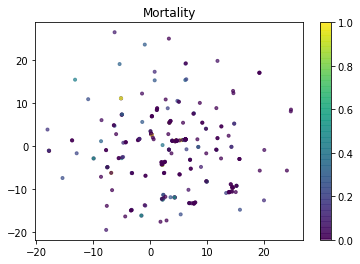

In [67]:
plt.scatter(h0_stat["h0_x"],h0_stat["h0_y"],c=h0_stat["y"],alpha=0.7,marker=".")
plt.colorbar()
plt.title("Mortality")

### hTでの病種別重心と死亡率

In [37]:
df_T=pd.DataFrame([cov,y,hT_2dim[:,0],hT_2dim[:,1]]).T
df_T.columns=["cov","y","hT_x","hT_y"]
df_T.head()

cov  y     hT_x     hT_y
0  430  1  6.84089  7.25657
1  574  0  8.07225  5.50274
2  197  0  11.7382  6.41781
3  200  1   7.4887  6.04812
4  414  0   13.269  4.51647

In [38]:
df_T["y"]=df_T["y"].astype(float)
df_T["hT_x"]=df_T["hT_x"].astype(float)
df_T["hT_y"]=df_T["hT_y"].astype(float)
hT_stat=df_T.groupby("cov").mean()

In [39]:
#hT_stat.iloc[:,1:3]=scaler.fit_transform(hT_stat.iloc[:,1:3])
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],alpha=0.7,marker=".")
plt.colorbar()
plt.title("Mortality")

Text(0.5, 1.0, 'Mortality')

### h1(24hour after from first record)での病種別重心と死亡率

In [40]:
df_1=pd.DataFrame([cov,y,h1_2dim[:,0],h1_2dim[:,1]]).T
df_1.columns=["cov","y","h1_x","h1_y"]
df_1["y"]=df_1["y"].astype(float)
df_1["h1_x"]=df_1["h1_x"].astype(float)
df_1["h1_y"]=df_1["h1_y"].astype(float)
h1_stat=df_1.groupby("cov").mean()

In [41]:
#h1_stat.iloc[:,1:3]=scaler.fit_transform(h1_stat.iloc[:,1:3])
#plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],cmap='OrRd',alpha=0.7)
plt.scatter(h1_stat["h1_x"],h1_stat["h1_y"],c=h1_stat["y"],alpha=0.7,marker=".")
plt.colorbar()
plt.title("Mortality")

Text(0.5, 1.0, 'Mortality')

## 個別データの利用
### hTでの全点表示
これを使って死亡予測をしているので、当然ある程度は傾向が見えるはず。

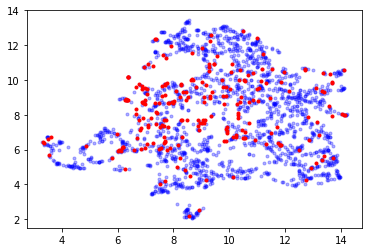

In [75]:
c=["blue","red"]
alpha=[0.3,1]
s=[10,5]
for i in range(2):
    plt.scatter(df_T[df_T["y"]==i]["hT_x"],df_T[df_T["y"]==i]["hT_y"],marker=".",color=c[i],alpha=alpha[i])


### h1での全点表示
途中の傾向を見ていることに大きな傾向が見えるか。

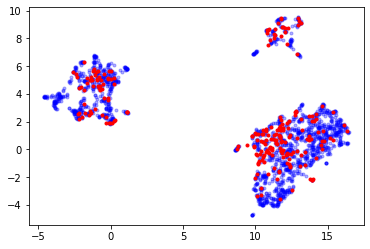

In [72]:
c=["blue","red"]
alpha=[0.3,1]
s=[10,5]
for i in range(2):
    plt.scatter(df_1[df_1["y"]==i]["h1_x"],df_1[df_1["y"]==i]["h1_y"],marker=".",color=c[i],alpha=alpha[i])


### h0での全点表示
事前情報として与えられたICD-9コードがモデルにより変換されたものに相当する

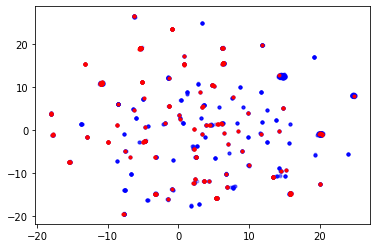

In [74]:
c=["blue","red"]
alpha=[0.3,1]
s=[10,5]
for i in range(2):
    plt.scatter(df_0[df_0["y"]==i]["h0_x"],df_0[df_0["y"]==i]["h0_y"],marker=".",color=c[i],alpha=alpha[i])


## sapsiiスコアとの連携
sapsiiスコアが歯抜けてある問題を何とかする。ひとまず-100で埋める

In [45]:
saps = pd.read_csv(saps_file_path)
saps = saps.loc[saps["ID"].isin(test_idx)].copy()
saps

ID  UNIQUE_ID  sapsii  sapsii_prob  age_score  hr_score  \
30        30      14226      69     0.826120         15       2.0   
51        51      10656      49     0.437547         18       2.0   
60        60       2988      39     0.229592         12       2.0   
89        89       1080      51     0.483852          7       0.0   
90        90      20079      44     0.326364         16       2.0   
...      ...        ...     ...          ...        ...       ...   
21207  21217      15351      54     0.552904         12       4.0   
21208  21218      11988      34     0.152870          7       0.0   
21220  21230       5775      34     0.152870         16       0.0   
21221  21231       3108      21     0.041754          7       0.0   
21227  21237      17537      42     0.285486          7       0.0   

       sysbp_score  temp_score  pao2fio2_score  uo_score  ...  \
30             5.0         0.0             6.0       0.0  ...   
51             5.0         0.0             6.0       0.0  ...   
60             5.0         0.0            11.0       0.0  ...   
89             5.0         0.0             9.0       0.0  ...   
90             5.0         0.0             6.0       0.0  ...   
...            ...         ...             ...       ...  ...   
21207          5.0         0.0             6.0       0.0  ...   
21208          2.0         0.0             9.0       0.0  ...   
21220          5.0         0.0             NaN       0.0  ...   
21221          5.0         0.0             NaN       0.0  ...   
21227          0.0         0.0             NaN      11.0  ...   

       potassium_score  sodium_score  bicarbonate_score  bilirubin_score  \
30                 3.0           1.0                3.0              NaN   
51                 0.0           0.0                3.0              4.0   
60                 0.0           0.0                0.0              0.0   
89                 3.0           0.0                5.0              0.0   
90                 3.0           0.0                0.0              NaN   
...                ...           ...                ...              ...   
21207              0.0           0.0                3.0              9.0   
21208              0.0           0.0                0.0              0.0   
21220              0.0           1.0                0.0              NaN   
21221              3.0           0.0                0.0              NaN   
21227              3.0           0.0                5.0              0.0   

       gcs_score  comorbidity_score  admissiontype_score  SUM_score         X  \
30          26.0                  0                    8       46.0 -0.533918   
51           0.0                  0                    8       23.0 -2.899163   
60           0.0                  9                    0       18.0 -3.500600   
89           0.0                 10                    6       28.0 -2.341969   
90           0.0                  0                    6       22.0 -3.015299   
...          ...                ...                  ...        ...       ...   
21207        0.0                  9                    6       27.0 -2.450659   
21208        7.0                  0                    6       21.0 -3.133322   
21220        0.0                  0                    6       12.0 -4.321189   
21221        0.0                  0                    6        8.0 -4.982647   
21227        0.0                  0                    6       29.0 -2.234466   

           PROB  
30     0.630396  
51     0.947805  
60     0.970705  
89     0.912294  
90     0.953261  
...         ...  
21207  0.920610  
21208  0.958246  
21220  0.986890  
21221  0.993191  
21227  0.903302  

[2125 rows x 22 columns]

In [46]:
saps["ID"].nunique(), len(test_idx)

(2125, 2126)

ひとつ抜けている。無理やり調べて-10で埋める<br>
列を刈り込むのと、PROBの計算式が(1-PROB)になってしまっているところを戻す（元コードであるDataMerging.ipynbは修正済み。再実行に時間を要するのでそちらを再度実施した際にこちらも直す。）<br>
SUM_scoreはsapsiiスコアのうち、カルテ情報（併発症、年齢、入室タイプを除いたものとしている。こちらはリアルタイムモニタリングを意識した数値となっている。）

In [47]:
temp = saps[["ID","sapsii","sapsii_prob","SUM_score","PROB"]]
temp["PROB"] = 1-temp["PROB"]
print(set(test_idx) - set(temp["ID"]))
temp

{13996}


ID  sapsii  sapsii_prob  SUM_score      PROB
30        30      69     0.826120       46.0  0.369604
51        51      49     0.437547       23.0  0.052195
60        60      39     0.229592       18.0  0.029295
89        89      51     0.483852       28.0  0.087706
90        90      44     0.326364       22.0  0.046739
...      ...     ...          ...        ...       ...
21207  21217      54     0.552904       27.0  0.079390
21208  21218      34     0.152870       21.0  0.041754
21220  21230      34     0.152870       12.0  0.013110
21221  21231      21     0.041754        8.0  0.006809
21227  21237      42     0.285486       29.0  0.096698

[2125 rows x 5 columns]

In [55]:
temp.loc[13996] = [13996, -10, -10, -10, -10]
sapsii = temp.sort_values("ID")
sapsii["Loader_ID"] = sapsii["ID"].map(map_dict)
sapsii = sapsii.sort_values("Loader_ID")  ##確定させる 
sapsii.index = sapsii["Loader_ID"].values
sapsii

ID  sapsii  sapsii_prob  SUM_score      PROB  Loader_ID
0        30      69     0.826120       46.0  0.369604          0
1        51      49     0.437547       23.0  0.052195          1
2        60      39     0.229592       18.0  0.029295          2
3        89      51     0.483852       28.0  0.087706          3
4        90      44     0.326364       22.0  0.046739          4
...     ...     ...          ...        ...       ...        ...
2121  21217      54     0.552904       27.0  0.079390       2121
2122  21218      34     0.152870       21.0  0.041754       2122
2123  21230      34     0.152870       12.0  0.013110       2123
2124  21231      21     0.041754        8.0  0.006809       2124
2125  21237      42     0.285486       29.0  0.096698       2125

[2126 rows x 6 columns]

In [68]:
df_0 = pd.concat([df_0,sapsii],axis=1)
df_0 = df_0[df_0["sapsii"]>0]
df_1 = pd.concat([df_1,sapsii],axis=1)
df_1 = df_1[df_1["sapsii"]>0]
df_T = pd.concat([df_T,sapsii],axis=1)
df_T = df_T[df_T["sapsii"]>0]

In [84]:
saps.columns

Index(['ID', 'UNIQUE_ID', 'sapsii', 'sapsii_prob', 'age_score', 'hr_score',
       'sysbp_score', 'temp_score', 'pao2fio2_score', 'uo_score', 'bun_score',
       'wbc_score', 'potassium_score', 'sodium_score', 'bicarbonate_score',
       'bilirubin_score', 'gcs_score', 'comorbidity_score',
       'admissiontype_score', 'SUM_score', 'X', 'PROB'],
      dtype='object')

### h0

Text(0.5, 1.0, 'Death Probability by SAPS II score')

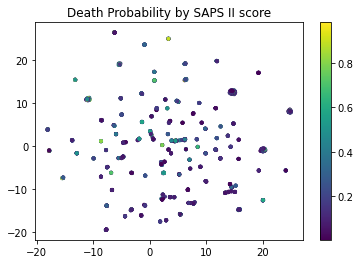

In [87]:
plt.scatter(df_0["h0_x"],df_0["h0_y"],c=df_0["sapsii_prob"],marker=".")
plt.colorbar()
plt.title("Death Probability by SAPS II score")
plt.savefig()

Text(0.5, 1.0, 'SAPS I (except age, comorbidity, admissiontype)')

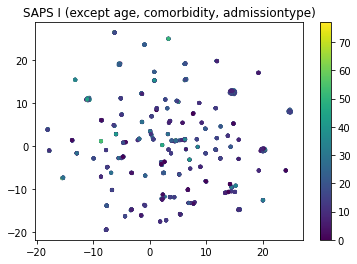

In [86]:
plt.scatter(df_0["h0_x"],df_0["h0_y"],c=df_0["SUM_score"],marker=".")
plt.colorbar()
plt.title("SAPS I (except age, comorbidity, admissiontype)")

### h1

Text(0.5, 1.0, 'Death Probability by SAPS II score')

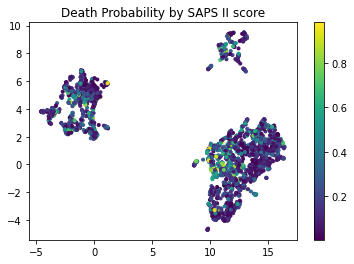

In [88]:
plt.scatter(df_1["h1_x"],df_1["h1_y"],c=df_1["sapsii_prob"],marker=".")
plt.colorbar()
plt.title("Death Probability by SAPS II score")

Text(0.5, 1.0, 'SAPS I (except age, comorbidity, admissiontype)')

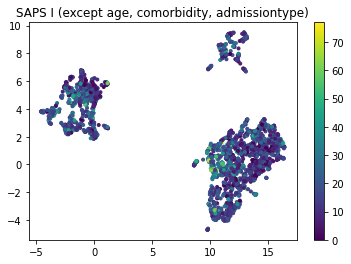

In [90]:
plt.scatter(df_1["h1_x"],df_1["h1_y"],c=df_1["SUM_score"],marker=".")
plt.colorbar()
plt.title("SAPS I (except age, comorbidity, admissiontype)")

### hT

Text(0.5, 1.0, 'Mortality')

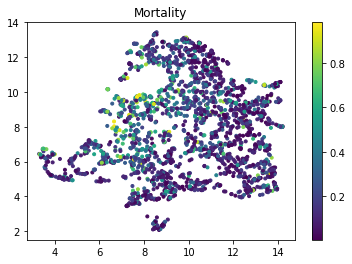

In [73]:
plt.scatter(df_T["hT_x"],df_T["hT_y"],c=df_T["sapsii_prob"],marker=".")
plt.colorbar()
plt.title("Mortality")

Text(0.5, 1.0, 'SAPS I (except age, comorbidity, admissiontype)')

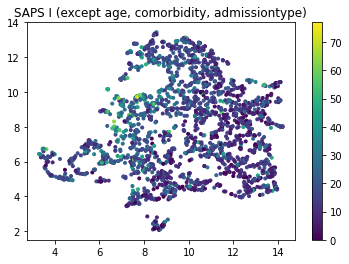

In [91]:
plt.scatter(df_T["hT_x"],df_T["hT_y"],c=df_T["SUM_score"],marker=".")
plt.colorbar()
plt.title("SAPS I (except age, comorbidity, admissiontype)")

## 分散の遷移をみる
ICD-9ごとにまとめた分散はどのように変化するのか
生存、死亡についてはどうか。

## 病種を大分類に

In [57]:
# ICD9をshortcodeからさらに大分類に分ける a-rまで
def classifyICD(code):
    if code.isdecimal():
        code=int(code)
        if code <=139:
            return "a" #infectious and parasitic diseases
        elif code<=239:
            return "b" #neoplasms
        elif code<=279:
            return "c" #endocrine, nutritional and metabolic diseases, and immunity disorders
        elif code<=289:
            return "d" #Diseases of the Blood and Blood-forming Organs
        elif code<=319:
            return  "e"#Mental Disorders
        elif code<= 359:
            return "f"# diseases of the nervous system
        elif code<= 389:
            return  "g"#sense organs
        elif code<= 459:
            return "h"# Diseases of the Circulatory System
        elif code<= 519 :
            return  "i"# Diseases of the Respiratory System
        elif code<= 579:
            return "j"# Diseases of the Digestive System
        elif code<= 629:
            return "k"# Diseases of the Genitourinary System
        elif code<= 679:
            return  "l"# Complications of Pregnancy, Childbirth, and the Puerperium
        elif code<= 709:
            return "m"#Diseases of the Skin and Subcutaneous Tissue
        elif code<= 739:
            return  "n"# Diseases of the Musculoskeletal System and Connective Tissue
        elif code<= 759:
            return  "o"# Congenital Anomalies
        elif code<= 779:
            return  "p"#Certain Conditions originating in the Perinatal Period
        elif code<= 799:
            return  "q"#Symptoms, Signs and Ill-defined Conditions
        elif code<= 999:
            return  "r"#Injury and Poisoning
    else:
        return "others"

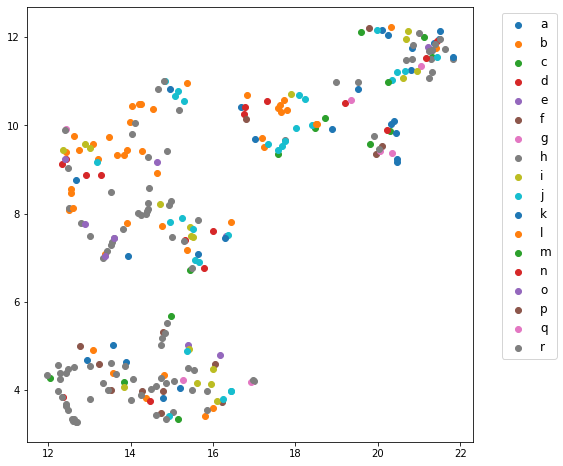

In [58]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean["category"]=h0_mean["cov"].map(classifyICD)
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(h0_mean[h0_mean["category"]==char]["h0_x"],h0_mean[h0_mean["category"]==char]["h0_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

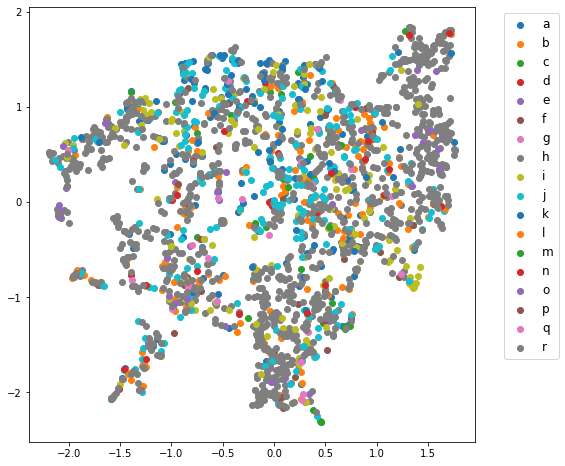

In [59]:
df_hT=copy.deepcopy(df)
df_hT["category"]=df_hT["cov"].map(classifyICD)
df_hT.head()
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(df_hT[df_hT["category"]==char]["hT_x"],df_hT[df_hT["category"]==char]["hT_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

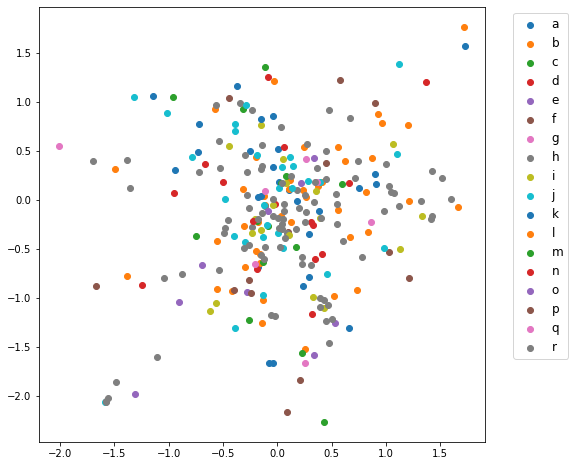

In [60]:
df_hT=copy.deepcopy(df)
df_hT=df_hT.groupby("cov").mean().reset_index()
df_hT["category"]=df_hT["cov"].map(classifyICD)
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(df_hT[df_hT["category"]==char]["hT_x"],df_hT[df_hT["category"]==char]["hT_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

## UMAP

In [ ]:
def draw_umap(data,label ,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure(figsize=(8,8))
    cmap="cool"
    if n_components == 1:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], range(len(u)), c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 2:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], u[:,1],c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=label, s=100,cmap=cmap)


    plt.title(title, fontsize=18)

In [ ]:
draw_umap(h0,h0_mean["y"],min_dist=0.2,n_components=3, title='n_components = 3')